----
# Tutorial for Evaluating Fairness in Binary Classification

----
# Overview

## All Models Are Biased

All machine learning models can be assumed to hold biases, just as all humans hold biases, and all humans fall ill at some point in their lives. The motivation that drives us to study and prevent the harm caused by human illness drives us to prevent the harm caused by innate biases. That means building models that provide fair representation for all demographics. This starts with measurement and evaluation.


## About this Tutorial

This notebook introduces concepts, methods, and libraries for measuring fairness in machine learning (ML) models as it relates to problems in healthcare. This is a revamped version of the tutorial presented at the [KDD 2020 Tutorial on Fairness in Machine Learning for Healthcare](../docs/publications/KDD2020-FairnessInHealthcareML-Slides.pptx), the notebook for which can be found here: [/docs/publications/KDD2020-FairnessInHealthcareML-TutorialNotebook.ipynb](../docs/publications/KDD2020-FairnessInHealthcareML-TutorialNotebook.ipynb).


[Part 1](#part1) and [Part 2](#part2) introduce a general background about fairness metrics and measures, and introduce our hypothetical example predicting Length of Stay (LOS) based on a subset of the [MIMIC-III clinical database](https://mimic.physionet.org/gettingstarted/access/). In [Part 3](#part3) this baseline model is used as an example to evaluate and discuss common metrics like *Disparate Impact*, *Equalized Odds*, and *Consistency Scores*. Then, [Part 4] compares the resuts of the baseline model to results for other modeling approaches: one "unaware" version, a "fairness-aware" version, and a third version simply using a different standard machine learning algorithm. 



There are abundant other publications covering the theoretical basis for fairness metrics, and many resources both online and academic covering the details of specific fairness measures (See [References (bottom)](#references) and [Additional Resources (bottom)](#additional_resources), or [Our Resources Page](../docs/Resources.pdf) for just a few). Many of these otherwise excellent references stop short of discussing  edge cases and the practical and philosophical considerations raised when evaluating real models for real customers. Here we attempt to bridge that gap.

**Please note: This notebook is intended as an introduction and reference and is not designed to work with outside models.**


## Want a Template? Evaluating Your Own Model?
We recommend using our [Template-BinaryClassificationAssessment](../templates/Template-BinaryClassificationAssessment.ipynb), which also has a useful example: [Example-Template-BinaryClassificationAssessment](Example-Template-BinaryClassificationAssessment.ipynb). The notebook you are currently reading is intended to provide guidance on the evaluation process and is not designed for use with external models.


## Table of Contents
[Part 1](#part1) - Framing the Problem
  * Background
    * Disparity & Harms
  * Example Model
    * Problem Definition
 
[Part 2](#part2) - Defining and Measuring Fairness (in Python)
  * Group Fairness Measures
  * Individual Fairness Measures
  
[Part 3](#part3) - Evaluating an Example Model
  * "Fair" Values
  * Comparing Group Fairness (Statistical) Measures
    * Problems with Group Fairness Measures
    * Impossibility Theorem of Fairness
  * Comparing Similarity-Based (e.g., Individual Fairness) Measures
    * Problems with Individual Fairness Measures
  * Choosing the Appropriate Measures
  
[Part 4](#part4) - Comparing Models 
  * Comparing Results
  * How fair is fair enough?
  
[References]()
  * Citations
  * Additional Resources and Tutorials
  * Other Python Libraries of Note
  * Fairness-Aware ML Algorithms


## Requirements

To run this notebook, please install FairMLHealth using [the instructions posted in GitHub](https://github.com/KenSciResearch/fairMLHealth#installation_instructions).

The tutorial uses data from the MIMIC III Critical Care database, a freely accessible source of electronic health records from Beth Israel Deaconess Medical Center in Boston. To download the MIMIC III data, please use this link: [Access to MIMIC III](https://mimic.physionet.org/gettingstarted/access/) and save the data with the default directory name ("MIMIC"). No further action is required beyond remembering the download location, and you do not need to unzip any files.

A basic knowledge of ML implementation in Python is assumed. 


----
---- 
# Part 1 - Framing the Problem <a class = "anchor" id = "part1"></a>

## Background
### Fairness in Machine Learning
In issues of social justice, discrimination is the unjustified, differential treatment of individuals based on their sociodemographic status [[Romei and Ruggieri 2014]](#romei2014_ref).  A "fair" model could be considered one that does not discriminate.

The "socially salient" sociodemographic groups [[Speicher 2018]](#speicher2018_ref) about which discrimination is measured are known as ***protected attributes***, *sensitive attributes*, or *protected features*. 

### Disparity  <a id="disparity_def"></a>

The term "discrimination" typically evokes direct or deliberate action to disadvantage one race, religion, or ethnicity. This kind of disparity is known as *disparate treatment*. However, a more insidious form of discrimination can occur when ostensibly unbiased practices result in the – perhaps unconscious – unfair treatment of a socially disadvantaged group. This is known as *disparate impact*. 

Disparate impact in a machine learning model originates from bias in either the data or the algorithms. A popular example is the prejudicially biased data used for recidivism prediction. Due to disparate socioeconomic factors and systemic racism in the United States, blacks have historically been (and continue to be) incarcerated at higher rates than whites [[NAACP]](#naacp).  Not coincidentally, blacks are also exonerated due to wrongful accusation at a considerably higher rate than whites [[NAACP]](#naacp).  A recidivism model that fails to adjust for circumstances such as these will predict a higher rate of recidivism among blacks. 

Machine learning models can also be a source of disparate impact in their implementation, through unconscious human biases that affect the fair interpretation or use of the model's results. This tutorial does not cover measurement of fairness at implementation. However, if you are interested in fair implementation, we recommend looking at Google's [Fairness Indicators](https://github.com/tensorflow/fairness-indicators).

### Harms

In evaluating the potential impact of an ML model, it can be helpful to first clarify what specific harm(s) can be caused by the model's failures. In the context of fairness, machine learning "harms" are commonly observed to fall into one of two categories.

* **Allocative Harm:** functionality promoting unfair allocation of finite resources
* **Representational Harm:** functionality promoting the continued marginalization of some groups
  * Examples include:
    * Quality of Service: allocating higher insurance payouts for males than for females
    * Stereotyping: service more likely to show advertising for bail bonds to dark skinned men
    * Under-Representation: image search for "doctor" returning mostly images of white men
    * Recognition: facial recognition mistakenly and offensively labeling a person as an animal 


References:
[The Trouble with Bias](https://youtu.be/fMym_BKWQzk) Kate Crawford, NIPS2017

## Problem Definition
Let's examine a model built for a hypothetical program providing early health and financial counseling to patients expected to experience a prolonged length of stay (LOS) in an ICU ward. The service is paid for by small donations from the community it serves. We have found that LOS for this program can be predicted with reasonable performance, and as contemporaries in the healthcare industry we would like to ensure that resources are distributed among our patients fairly. 

Our baseline model will use the patient's age, diagnosis, language, and the use of medical procedures during their stay to predict this value. Our model produces a binary prediction indicating indicating whether or not the LOS for a given admission is greater than the mean. Observations have been dropped where LOS values are extremely large (30 days or greater) or negative (indicating that the patient was deceased upon arrival at the ICU).


In [1]:
# Standard Libraries
from IPython.display import Markdown, HTML
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import stats
import sys
import warnings

# Load Prediction Libraries
import sklearn.metrics as sk_metric
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# Remove limit to the number of columns and column widths displayed by pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 0) # adjust column width as needed

# Load AIF360 Measures
import aif360.sklearn.metrics as aif_skmetrics

# Load Fairlearn Measures
import fairlearn


### Below are helper functions that make the tutorial easier to read

In [3]:
# Helpers from local folder
from fairmlhealth.mimic_data import load_mimic3_example
from fairmlhealth.model_comparison import measure_model, compare_models
from fairmlhealth.reports import flag 
from fairmlhealth import reports, stratified_reports

# Functions and pointers to make this tutorial more colorful
ks_magenta = '#d00095'
ks_magenta_lt = '#ff05b8'
ks_purple = '#947fed'


### Loading the MIMIC III Data Subset <a id="datasubset"></a>

As mentioned above, the MIMIC-III data download contains a folder of zipped_files. The tutorial code in the [Data Subset](#datasubset) section below will automatically unzip and format all necessary data for these experiments, saving the formatted data in the same MIMIC folder. Simply enter the correct path of the MIMIC folder in the following cell to enable this feature. Your path should end with the directory "MIMIC".

Example: path_to_mimic_data_folder = "~/data/MIMIC"

In [4]:
# path_to_mimic_data_folder = "[path to your downloaded data folder]"
path_to_mimic_data_folder = "~/data/MIMIC"

Example models in this notebook use data from all years of the MIMIC-III dataset for patients aged 65 and older. Data are imported at the encounter level with all additional patient identification dropped. All models include an "AGE" feature, simplified to 5-year bins, as well as Boolean diagnosis and procedure features categorized through the Clinical Classifications Software system ([HCUP](https://www.hcup-us.ahrq.gov/toolssoftware/ccs/ccs.jsp)). All features other than age are one-hot encoded and prefixed with their variable type (e.g. "GENDER_", "ETHNICITY_").  

In [5]:
# Load data and subset to ages 65+
df = load_mimic3_example(path_to_mimic_data_folder) 
df = df.loc[df['AGE'].ge(65), :]
df.drop('GENDER_F', axis=1, inplace=True) # Redundant with GENDER_M

display(df.head(2))

,ADMIT_ID,AGE,GENDER_M,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ETHNICITY_ASIAN,ETHNICITY_ASIAN - ASIAN INDIAN,ETHNICITY_ASIAN - CAMBODIAN,ETHNICITY_ASIAN - CHINESE,ETHNICITY_ASIAN - FILIPINO,ETHNICITY_ASIAN - JAPANESE,ETHNICITY_ASIAN - KOREAN,ETHNICITY_ASIAN - OTHER,ETHNICITY_ASIAN - THAI,ETHNICITY_ASIAN - VIETNAMESE,ETHNICITY_BLACK/AFRICAN,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_BLACK/CAPE VERDEAN,ETHNICITY_BLACK/HAITIAN,ETHNICITY_CARIBBEAN ISLAND,ETHNICITY_HISPANIC OR LATINO,ETHNICITY_HISPANIC/LATINO - CENTRAL AMERICAN (OTHER),ETHNICITY_HISPANIC/LATINO - COLOMBIAN,ETHNICITY_HISPANIC/LATINO - CUBAN,ETHNICITY_HISPANIC/LATINO - DOMINICAN,ETHNICITY_HISPANIC/LATINO - GUATEMALAN,ETHNICITY_HISPANIC/LATINO - HONDURAN,ETHNICITY_HISPANIC/LATINO - MEXICAN,ETHNICITY_HISPANIC/LATINO - PUERTO RICAN,ETHNICITY_HISPANIC/LATINO - SALVADORAN,ETHNICITY_MIDDLE EASTERN,ETHNICITY_MULTI RACE ETHNICITY,ETHNICITY_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,ETHNICITY_OTHER,ETHNICITY_PATIENT DECLINED TO ANSWER,ETHNICITY_PORTUGUESE,ETHNICITY_SOUTH AMERICAN,ETHNICITY_UNABLE TO OBTAIN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_WHITE,ETHNICITY_WHITE - BRAZILIAN,ETHNICITY_WHITE - EASTERN EUROPEAN,ETHNICITY_WHITE - OTHER EUROPEAN,ETHNICITY_WHITE - RUSSIAN,LANGUAGE_* BE,LANGUAGE_* FU,LANGUAGE_** T,LANGUAGE_**SH,LANGUAGE_**TO,LANGUAGE_*AMH,LANGUAGE_*ARA,LANGUAGE_*ARM,LANGUAGE_*BEN,LANGUAGE_*BOS,LANGUAGE_*BUL,LANGUAGE_*BUR,LANGUAGE_*CAN,LANGUAGE_*CDI,LANGUAGE_*CHI,LANGUAGE_*DEA,LANGUAGE_*DUT,LANGUAGE_*FAR,LANGUAGE_*FIL,LANGUAGE_*FUL,LANGUAGE_*GUJ,LANGUAGE_*HUN,LANGUAGE_*IBO,LANGUAGE_*KHM,LANGUAGE_*LEB,LANGUAGE_*MAN,LANGUAGE_*MOR,LANGUAGE_*NEP,LANGUAGE_*PER,LANGUAGE_*PHI,LANGUAGE_*PUN,LANGUAGE_*SPA,LANGUAGE_*TAM,LANGUAGE_*TOI,LANGUAGE_*TOY,LANGUAGE_*URD,LANGUAGE_*YID,LANGUAGE_*YOR,LANGUAGE_ALBA,LANGUAGE_AMER,LANGUAGE_ARAB,LANGUAGE_BENG,LANGUAGE_CAMB,LANGUAGE_CANT,LANGUAGE_CAPE,LANGUAGE_ENGL,LANGUAGE_ETHI,LANGUAGE_FREN,LANGUAGE_GREE,LANGUAGE_HAIT,LANGUAGE_HIND,LANGUAGE_ITAL,LANGUAGE_JAPA,LANGUAGE_KORE,LANGUAGE_LAOT,LANGUAGE_MAND,LANGUAGE_PERS,LANGUAGE_POLI,LANGUAGE_PORT,LANGUAGE_PTUN,LANGUAGE_RUSS,LANGUAGE_SERB,LANGUAGE_SOMA,LANGUAGE_SPAN,LANGUAGE_TAGA,LANGUAGE_THAI,LANGUAGE_TURK,LANGUAGE_URDU,LANGUAGE_VIET,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay,MARRIED_DIVORCED,MARRIED_LIFE PARTNER,MARRIED_MARRIED,MARRIED_SEPARATED,MARRIED_SINGLE,MARRIED_UNKNOWN (DEFAULT),MARRIED_WIDOWED,RELIGION_7TH DAY ADVENTIST,RELIGION_BAPTIST,RELIGION_BUDDHIST,RELIGION_CATHOLIC,RELIGION_CHRISTIAN SCIENTIST,RELIGION_EPISCOPALIAN,RELIGION_GREEK ORTHODOX,RELIGION_HEBREW,RELIGION_HINDU,RELIGION_JEHOVAH'S WITNESS,RELIGION_JEWISH,RELIGION_LUTHERAN,RELIGION_METHODIST,RELIGION_MUSLIM,RELIGION_NOT SPECIFIED,RELIGION_OTHER,RELIGION_PROTESTANT QUAKER,RELIGION_ROMANIAN EAST. ORTH,RELIGION_UNITARIAN-UNIVERSALIST,RELIGION_UNOBTAINABLE,DIAGNOSIS_CCS_0,DIAGNOSIS_CCS_1,DIAGNOSIS_CCS_2,DIAGNOSIS_CCS_3,DIAGNOSIS_CCS_4,DIAGNOSIS_CCS_5,DIAGNOSIS_CCS_6,DIAGNOSIS_CCS_7,DIAGNOSIS_CCS_8,DIAGNOSIS_CCS_9,DIAGNOSIS_CCS_10,DIAGNOSIS_CCS_11,DIAGNOSIS_CCS_12,DIAGNOSIS_CCS_13,DIAGNOSIS_CCS_14,DIAGNOSIS_CCS_15,DIAGNOSIS_CCS_16,DIAGNOSIS_CCS_17,DIAGNOSIS_CCS_18,DIAGNOSIS_CCS_19,DIAGNOSIS_CCS_20,DIAGNOSIS_CCS_21,DIAGNOSIS_CCS_22,DIAGNOSIS_CCS_23,DIAGNOSIS_CCS_24,DIAGNOSIS_CCS_25,DIAGNOSIS_CCS_26,DIAGNOSIS_CCS_27,DIAGNOSIS_CCS_28,DIAGNOSIS_CCS_29,DIAGNOSIS_CCS_30,DIAGNOSIS_CCS_31,DIAGNOSIS_CCS_32,DIAGNOSIS_CCS_33,DIAGNOSIS_CCS_34,DIAGNOSIS_CCS_35,DIAGNOSIS_CCS_36,DIAGNOSIS_CCS_37,DIAGNOSIS_CCS_38,DIAGNOSIS_CCS_39,DIAGNOSIS_CCS_40,DIAGNOSIS_CCS_41,DIAGNOSIS_CCS_42,DIAGNOSIS_CCS_43,DIAGNOSIS_CCS_44,DIAGNOSIS_CCS_45,DIAGNOSIS_CCS_46,DIAGNOSIS_CCS_47,DIAGNOSIS_CCS_48,DIAGNOSIS_CCS_49,DIAGNOSIS_CCS_50,DIAGNOSIS_CCS_51,DIAGNOSIS_CCS_52,DIAGNOSIS_CCS_53,DIAGNOSIS_CCS_54,DIAGNOSIS_CCS_55,DIAGNOSIS_CCS_56,DIAGNOSIS_CCS_57,DIAGNOSIS_CCS_58,DIAGNOSIS_CCS_59,DIAGNOSIS_CCS_60,DIAGNOSIS_CCS_61,DIAGNOSIS_CCS_62,DIAGNOS

In [6]:
# Generate a binary target flagging whether an observation's length_of_stay value is above or below the mean. 
mean_val = df['length_of_stay'].mean()
df['long_los'] = df['length_of_stay'].apply(lambda x: 1 if x > mean_val else 0)


### Generating the Model <a id="generatemodel"></a>


---

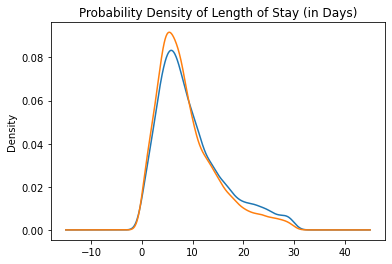

In [7]:
# Display LOS distributions
display(Markdown('---'))
df['LANG_ENGL'] = 0
df.loc[df['LANGUAGE_ENGL'].eq(1), 'LANG_ENGL'] = 1
ax = df.groupby('LANG_ENGL')['length_of_stay'
        ].plot(kind='kde', 
               title="Probability Density of Length of Stay (in Days)")
plt.show()

In [8]:
# Subset and Split Data
X = df.loc[:, [c for c in df.columns 
                if (c.startswith('AGE') 
                or c.startswith('DIAGNOSIS_') 
                or c.startswith('PROCEDURE_'))]]
X['LANG_ENGL'] = 0
X.loc[df['LANGUAGE_ENGL'].eq(1), 'LANG_ENGL'] = 1
y = df.loc[:, ['long_los']]


#
splits = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = splits

# Set model parameters (defined here for consistency throughout models)
xgb_params = {'colsample_bytree': 1.0, 'gamma': 2, 
              'learning_rate': 0.05, 'max_depth': 5, 
              'min_child_weight': 1, 'n_estimators': 600, 
              'subsample': 0.6}

rf_params = {'n_estimators': 1800, 'min_samples_split': 5, 'bootstrap': False}

In [9]:
# Train New Model with Language Feature
model = XGBClassifier(**xgb_params)
model.fit(X_train, y_train.iloc[:, 0])
y_pred = model.predict(X_test)


### FairMLHealth Stratified Data Reporter

FairMLHealth includes stratified reporting features to aid in identifying the source of unfairness or other bias. The data reporter evaluates basic statistics specific to each feature-value, in addition to relative statistics for the target value. Since the reporter can evaluate many features at once, it can be a useful option for identifying patterns of bias either alone or in concert with other (e.g., visual methods).

In [10]:
print("FairMLHealth Stratified Data Report")
stratified_reports.data_report(X_test, y_test, features=['LANG_ENGL'])


FairMLHealth Stratified Data Report


,FEATURE,FEATURE VALUE,N OBS,N MISSING,FEATURE ENTROPY,VALUE PREVALENCE,Y MAX,Y MEAN,Y MEDIAN,Y MIN,Y STDV
0,ALL_FEATURES,ALL_VALUES,7404.0,0,NaN,1.0000,1.0,0.3880,0.0,0.0,0.4873
1,LANG_ENGL,0,3356.0,0,0.9937,0.4533,1.0,0.4195,0.0,0.0,0.4936
2,LANG_ENGL,1,4048.0,0,0.9937,0.5467,1.0,0.3619,0.0,0.0,0.4806


----
----
# Part 2 - Defining and Measuring Fairness <a id="part2"></a>

The following section defines common fairness measures that are used elsewhere in the notebook. Skip ahead to [Part 3](#part3) for an example of how these measures are applied.

### [Convenient Charts of Fairness Measures](../docs/Summary_Tables.pdf)

### Definitions of Fairness  <a id="metric_quickref"></a>

There are six common metrics for determining whether a model is considered "fair": Equal Treatment ("**Unawareness**"), **Demographic Parity**, **Equalized Odds**, **Predictive Parity**, **Individual Fairness**, and **Counterfactual Fairness**. 


<h3 style="text-align: center; "><u>  Statistical Criteria for Fairness Metrics </u> </h3> 

|Metric |Statistical Criteria |Definition |Description |
|-|-|-|-|
|Demographic Parity|Statistical Independence |R ⊥ G |sensitive attributes (A) are statistically independent of the prediction result (R) |
|Equalized Odds| Statistical Separation |R ⊥ A\|Y |sensitive attributes (A) are statistically independent of the prediction result (R) given the ground truth (Y) |
|Predictive Parity |Statistical Sufficiency |Y ⊥ A\|R |sensitive attributes (A) are statistically independent of the ground truth (Y) given the prediction (R) |


<h3 style="text-align: center; "><u>  Definitions of Fairness </u> </h3> 

| Category | Metric | Definition | Weakness | References |
|------|------|------|------|------|
| Group Fairness |**Demographic Parity**| A model has **Demographic Parity** if the predicted positive rates (selection rates) are approximately the same for all protected attribute groups. $$\dfrac{P(\hat{y} = 1 \lvert unprivileged)}{P(\hat{y} = 1 \rvert privileged)}$$ <br> Harms Addressed: Allocative| Historical biases present in the data are not addressed and may still bias the model. | [Zafar *et al* (2017)](#zafar2017_ref) |
||**Equalized Odds**| Odds are equalized if $P(+)$ is approximately the same for all protected attribute groups.<br>  **Equal Opportunity** is a special case of equalized odds specifying that $$P(+ \rvert y = 1)$$ is approximately the same across groups. <br> Harms Addressed: Allocative, Representational | Historical biases present in the data  are not addressed and may still bias the model. | [Hardt *et al* (2016)](#hardt2016_ref) |
||**Predictive Parity**| This parity exists where the Positive Predictive Value is approximately the same for all protected attribute groups. <br> Harms Addressed: Allocative, Representational | Historical biases present in the data are not addressed and may still bias the model.  | [Zafar *et al* (2017)](#zafar2017_ref) |
||||||
| Similarity-Based Measures |**Individual Fairness**| Individual fairness exists if "similar" individuals (ignoring the protected attribute) are likely to have similar predictions. <br>Harms Addressed: Representational | The appropriate metric for similarity may be ambiguous. |[Dwork (2012)](#dwork2012_ref), [Zemel (2013)](#zemel2013_ref), [Kim *et al* (2018)](#kim2018_ref) |
| &nbsp; |**Unawareness** | A model is unaware if the protected attribute is not used.  | Removal of a protected attribute may be ineffectual due to the presence of proxy features highly correlated with the protected attribute.| [Zemel *et al* (2013)](#zemel2013_ref), [Barocas and Selbst (2016)](#barocas2016_ref) |
||||||
| Causal Reasoning |**Counterfactual Fairness** \*| Counterfactual fairness exists where counterfactual replacement of the protected attribute does not significantly alter predictive performance. This counterfactual change must be propogated to correlated variables. <br>Harms Addressed: Allocative, Representational | It may be intractable to develop a counterfactual model.  | [Russell *et al* (2017)](#russell2017_ref) |
||||||

\* *Note that this tutorial will not elaborate the details of Counterfactual Fairness since the libraries used do not have built-in functionality for it. For an example of Counterfactual Fairness, see "ThemisML" by [Bantilan (2018)](#bantilan2018_ref).*



## Group Fairness Measures

### Demographic Parity  <a id="dem_parity"></a>
A model has **Demographic Parity** if the predicted positive rates (selection rates) are approximately the same for all groups of the protected attribute. Two common measures are the Statistical Parity Difference and the Disparate Impact Ratio.

The *Statistical Parity Difference* is the difference in the probability of prediction between the two groups. A difference of 0 indicates that the model is perfectly fair relative to the protected attribute (it favors neither the privileged nor the unprivileged group). Values between -0.1 and 0.1 are considered reasonably fair. 
> $statistical\_parity\_difference = P(\hat{y} = 1\ |\ unprivileged) - P(\hat{y} = 1\ |\ privileged) $

The *Disparate Impact Ratio* is the ratio between the probability of positive prediction for the unprivileged group and the probability of positive prediction for the privileged group. A ratio of 1 indicates that the model is fair relative to the protected attribute (it favors neither the privileged nor the unprivileged group).  Values between 0.8 and 1.2 are considered reasonably fair. 
> $disparate\_impact\_ratio = \dfrac{P(\hat{y} = 1\ |\ unprivileged)}{P(\hat{y} = 1\ |\ privileged)} = \dfrac{selection\_rate(\hat{y}_{unprivileged})}{selection\_rate(\hat{y}_{privileged})}$

### Equal Odds
Odds are equalized if P(+) is approximately the same for all groups of the protected attribute.

The *Equalized Odds Difference* is the greater between the difference in TPR and the difference in FPR. This provides a comparable measure to the Average Odds Difference found in AIF360. A value of 0 indicates that all groups have the same TPR, FPR, TNR, and FNR, and that the model is "fair" relative to the protected attribute. 
> $ equalized\_odds\_difference = max( (FPR_{unprivileged} - FPR_{privileged}), (TPR_{unprivileged} - TPR_{privileged}) )$

The *Equalized Odds Ratio* is the smaller between the TPR Ratio and FPR Ratio, where the ratios are defined as the ratio of the smaller of the between-group rates vs the larger of the between-group rates. A value of 1 means that all groups have the same TPR, FPR, TNR, and FNR. This measure is comparable to the Equal Opportunity Difference (found in AIF360).
> $ equalized\_odds\_ratio = min( \dfrac{FPR_{smaller}}{FPR_{larger}}, \dfrac{TPR_{smaller}}{TPR_{larger}} )$

*Equal Opportunity Difference (or Ratio)* compares the recall scores (TPR) between the unprivileged and privileged groups. 
> $equal\_opportunity\_difference = recall(\hat{y}_{unprivileged}) - recall(\hat{y}_{privileged})$


### Measures of Disparate Performance
These measures evaluate whether model performance is similar for all groups of the protected attribute.

The *Positive Predictive Parity Difference (or Ratio)* compares the Positive Predictive Value (PPV), aka. precision, between groups. 
> $positive\_predictive\_parity\_difference = precision(\hat{y}_{unprivileged}) - precision(\hat{y}_{privileged})$

The *Balanced Accuracy Difference (or Ratio)* compares the Balanced Accuracy between groups, where balanced accuracy is the mean of the sensitivity and specificity. **Since many models are biased due to data imbalance, this can be an important measure.**
> $balanced\_accuacy\_difference = (Sensitivity_{unprivileged} + Specificity_{unprivileged})/2 - (Sensitivity_{privileged} + Specificity_{privileged})/2$

## Individual Fairness Measures
Measures of individual fairness determine if "similar" individuals (ignoring the protected attribute) are likely to have similar predictions.

### Consistency Scores <a id="consistency_score"></a>
Consistency scores measure the similarity between specific predictions and the predictions of like individuals. They are not specific to a particular attribute, but rather they evaluate the generally equal treatment of equal individuals. In AIF360, the consistency score is calculated as the compliment of the mean distance to the score of the mean nearest neighbor, using Scikit's Nearest Neighbors algorithm (default: 5 neighbors determined by the Ball Tree algorithm). For this measure, values closer to 1 indicate greater consistency, and those closer to zero indicate less consistency. More information about consistency scores is available in [[Zemel (2013)]](#zemel2013_ref).
> $ consistency\_score = 1 - \frac{1}{n\cdot\text{n_neighbors}}\sum_{i = 1}^n |\hat{y}_i - \sum_{j\in\mathcal{N}_{\text{n_neighbors}}(x_i)} \hat{y}_j| $


### The Generalized Entropy Index and Related Measures
The *Generalized Entropy (GE) Index* was proposed as a metric for income inequality [[Shorrocks (1980)]](#shorrocks_ref)), although it originated as a measure of redundancy in information theory. In 2018, [Speicher *et al.*](#speicher2018_ref) proposed its use for ML models. These measures are dimensionless, and therefore are most useful in comparison relative to each other. Values closer to zero indicate greater fairness, and increasing values indicating decreased fairness.
> $ GE = \mathcal{E}(\alpha) = \begin{cases}
            \frac{1}{n \alpha (\alpha-1)}\sum_{i = 1}^n\left[\left(\frac{b_i}{\mu}\right)^\alpha - 1\right],& \alpha \ne 0, 1,\\
            \frac{1}{n}\sum_{i = 1}^n\frac{b_{i}}{\mu}\ln\frac{b_{i}}{\mu},& \alpha = 1,\\
            -\frac{1}{n}\sum_{i = 1}^n\ln\frac{b_{i}}{\mu},& \alpha = 0.
        \end{cases}
        $
        
#### Special Cases      
The *Theil Index* occurs where the $GE$ alpha is equal to one. Although it is dimensionless like other indices of generalized entropy, it can be transformed into an Atkinson index, which has a range between 0 and 1.
> $ Theil Index = GE(\alpha = 1) $

The *Coefficient  of  Variation* is two times the square root of the $GE$ where alpha is equal to 2.
> $ Coefficient of Variation = 2*\sqrt{GE(\alpha = 2)} $

#### Generalized Entropy of Error
*Generalized Entropy Error* is the Generalized Entropy Index of the prediction error. Like the Consistency Score above, this measure is dimensionless; however, it does not provide specific information to allow discernment between groups.
> $ GE(Error, \alpha = 2) = GE(\hat{y}_i - y_i + 1) $

*Between Group Generalized Entropy Error* is the Generalized Entropy Index for the weighted means of group-specific errors. More information is available in [Speicher (2013)](#speicher2018_ref).
> $ GE(Error_{group}, \alpha = 2) = GE( [N_{unprivileged}*mean(Error_{unprivileged}), N_{privileged}*mean(Error_{privileged})] ) $



## See Also

### [Summary Tables:  Convenient Charts of Fairness Measures](../docs/Summary_Tables.pdf)

----
----
# Part 3 - Evaluating the Example Model <a id="part3"></a>
In this section we will evaluate an array of fairness measures for a single model. Skip ahead to [Part 4](#part4) for an example comparing multiple models against each other.

Our experiment tests sociodemographic bias as it relates to language. Here we suppose that individuals who speak English may be given preferential treatment in an English-speaking society due to the requirement of using a translator. Language may also be used as a proxy for race, religion, or nationality, which are [explicitly protected attributes](https://www.eeoc.gov/employers/small-business/3-who-protected-employment-discrimination).


# "Fair" Values 
FairMLHealth's measure_model tool outputs a table of results for an array of fairness measures. Below we apply a flagger to the resulting table, which simply highlights values that are out of range.


In [11]:
lang_values = X_test['LANG_ENGL']

In [12]:
print("FairMLHealth Fairness Measure Report: English Language")
fairness_report = measure_model(X_test, y_test, lang_values, model)
reports.flag(fairness_report)

FairMLHealth Fairness Measure Report: English Language


### FairMLHealth Stratified Performance Reporter

The stratified classification_performance reporter evaluates model performance specific to each feature-value subset. In this example we can see that the Equalized Odds ratio is out of range because of the significant difference in False Positive Rates (FPR) between the two classes. More about this difference in [Comparing Group Fairness Measures](#comparing_group_measures) below.

Note that if prediction probabilities (via the *predict_proba()* method) are available to the model, additional ROC_AUC and PR_AUC values will be included in the report.

In [13]:
print("FairMLHealth Stratified Performance Report")
stratified_reports.classification_performance(X_test, y_test, y_pred, features=['LANG_ENGL'])

FairMLHealth Stratified Performance Report


,FEATURE,FEATURE VALUE,N OBS,TRUE MEAN,PRED MEAN,ACCURACY,FNR,FPR,PRECISION (PPV),PR_AUC,ROC_AUC,TNR,TPR
0,ALL_FEATURES,ALL_VALUES,7404.0,0.3880,0.3210,0.7853,0.3630,0.1207,0.7699,0.3060,0.5,0.8793,0.6370
1,LANG_ENGL,0,3356.0,0.4195,0.3555,0.7732,0.3466,0.1401,0.7712,0.2902,0.5,0.8599,0.6534
2,LANG_ENGL,1,4048.0,0.3619,0.2925,0.7952,0.3788,0.1061,0.7686,0.3190,0.5,0.8939,0.6212


## Comparing Group Fairness (Statistical) Measures <a id="comparing_group_measures"></a>
The highlighted row in the cell above indicates that the Disparate Impact ratio is out of range, but what is that range and how is it determined? In 1978, the United States Equal Employment Opportunity Commission adopted the "Four-Fifths Rule", a guideline stating that, "A selection rate for any race, sex, or ethnic group which is less than four-fifths (4/5) (or eighty percent) of the rate for the group with the highest rate will generally be regarded... as evidence of adverse impact."[EOC (1978)](#fourfifths_ref) This rubric has since been adopted for measures of fairness in ML. This translates to a "fair" range of selection rate ratios that are between 0.8 and 1.2.

The four-fifths rule works well when comparing prediction performance metrics whose values are above 0.5. However, the rule fails when comparing small values, as is the case in this example and which is as shown in the stratified report in the cell below. The ratios between two such small values can easily be well above 1.2, even though the true difference is only a few percentage points. For this reason it's useful to compare both the ratios and the differences when evaluating group measures.

Returning to the language example in the cell above: the Disparate Impact Ratio and Statistical Parity Difference are two related measures that compare the selection rates between the protected and unprotected groups. Although the Disparate Impact Ratio in our example is outside of the "fair" range for ratios (it's above 1.2), the Statistical Parity Difference is well within range for differences. We can see why more clearly by examining the Stratified Performance Report (also above). Here we see that the selection rates (shown as: "POSITIVE PREDICTION RATES") are actually quite close. The same is true for the Equalized Odds Ratio, which also appears outside of the "fair" range. The Equalized Odds Difference is actually quite small, which we can understand more clearly by looking at the True Positive Rates and False Positive Rates (shown as TPR and FPR) in the Stratified Report.

|Group Measure Type |Examples |"Fair" Range |Favored Group |
|----|----|----|
|Statistical Ratio |Disparate Impact Ratio, Equalized Odds Ratio | 0.8 <= "Fair" <= 1.2 | < 1 favors privileged group, > 1 favors unprivileged |
|Statistical Difference |Equalized Odds Difference, Predictive Parity Difference | -0.1 <= "Fair" <= 0.1 | < 0 favors privileged group, > 0 favors unprivileged |

### Problems with Group Fairness Measures
Although these statistically-based measures make intuitive sense, they are not applicable in every situation. For example, Demographic Parity is inapplicable where the base rates significantly differ between groups. Also, by evaluating protected attributes in pre-defined groups, these measures may miss certain nuance. For example, a model may perform unfairly for certain sub-groups of the unprivileged class (e.g., black females), but not for the unprivileged group as a whole. 


### The Impossibility Theorem of Fairness <a id="impossibility"></a>
Another drawback of these statistically-based measures is that they are mathematically incompatible. No machine learning model can be perfectly fair according to all three metrics at once. People + AI Research (PAIR) posted an [excellent visual explanation of the Impossibility Theorem](https://pair.withgoogle.com/explorables/measuring-fairness/).

### FairMLHealth Stratified Fairness Reporter

The stratified classification_fairness reporter evaluates model fairness specific to each feature-value subset. It assumes each feature-value as the "privileged" group relative to all other possible values for the feature. To simplify the report, fairness measures have been simplified to their component parts. For example, measures of Equalized Odds can be determined by combining the True Positive Rate (TPR) Ratios & Differences with False Positive Rate (FPR) Ratios & Differences.

In [14]:
print("FairMLHealth Stratified Fairness Report")
stratified_reports.classification_fairness(X_test, y_test, y_pred, features=['LANG_ENGL'])

FairMLHealth Stratified Fairness Report


,FEATURE,FEATURE VALUE,N OBS,FNR Diff,FNR Ratio,FPR Diff,FPR Ratio,PPV Diff,PPV Ratio,TNR Diff,TNR Ratio,TPR Diff,TPR Ratio
0,LANG_ENGL,0,3356.0,0.0322,1.0930,-0.0341,0.7569,-0.0026,-0.0026,0.0341,1.0396,-0.0322,0.9506
1,LANG_ENGL,1,4048.0,-0.0322,0.9149,0.0341,1.3211,0.0026,0.0026,-0.0341,0.9619,0.0322,1.0519


## Comparing Similarity-Based Measures
Some measures of Individual Fairness are dimensionless, and for that reason they are most useful when comparing multiple models [as we will see in Part 4](#part4). However, some measures such as the Consistency Score and Between-Group Generalized Entropy Error exist on scales from 0 to 1. The directions of these scales can differ between measures (i.e., perfect fairness may lie at either 0 or at 1 depending upon the measure), so you will want to make a note of which applies. For example, for the Consistency Score shown above, a score of 1 is considered perfectly "fair". Adapting the four-fifths rule, we can say that a model should be consistent for at least 80% of predictions. By this measure, our example model above is out of range.

### Problems with Similarity-Based Fairness Measures
Similarity-based measures are not without their own drawbacks. The Consistency Score, for example, uses scikit's standard K-Nearest Neighbors (KNN) algorithm to define similarity, which may need additional (separate) parameter tuning, can be sensitive to irrelevant features, and may not be appropriate in cases of high dimensionality, sparse data or missingness. This then begs the question: *is the Consistency Score out of range because our prediction model is unfair, or because we haven't properly tuned the KNN algorithm?* Without significant additional work we cannot rule out the latter. Even supposing that a properly fit KNN model is possible, the results still may not be the most appropriate measure of similarity. For example, slthough diseases and procedures may be predictive, can it be said that all cardiac arrest survivors who recieved an Echocardiogram should be predicted to spend the same amount of time in the ICU?


##  Choosing the Appropriate Measure(s)
Our choice of measure is informed both by the use cases for each particular measure, and also by the problem context and by the preferences of the community(ies) affected by the model. Unfortunately this means that Unfortunately no one "correct" way to measure fairness. This also means that there is no one "correct" way to demonstarate that fairness. The burden is on the Data Scientist to transparently document their process and prove that they've taken reasonable steps to develop and to measure a model that is as fair as reasonably possible.

Although no model can be perfectly fair according to all metrics per the [Impossibility Theorem (above)](#impossibility), ideally a model will be at least within the range of fairness across the measures. From there, it's a matter of optimization for the specific measure(s) that is most applicable to the problem at hand. Thus the process begins with a clear understanding of the stakeholders and how they will view the potential outcomes. For healthcare models, the stakeholders are typically the patients, care providers, and the community(ies) being served, although it is likely that the care providers will represent the interests of the other two. It can also be helpful to create a table of outcomes, similar to the one below, to clearly document the harms, benefits, and preferences involved. 

See Also: [Value Sensitive Design](https://en.wikipedia.org/wiki/Value_sensitive_design)



<h3 style="text-align: center; "><u> Example Table of Outcomes </u> </h3>

|Prediction |Outcomes | Preference |
|-|-|-|
|TP |Benefit: Deserving patient recieves help |high importance |
|TN |Benefit: Community resources saved |less important |
|FP |Harm: community resources wasted on an individual without need |less important (to avoid) |
|FN |Harm: reduced likelihood of recovery |high importance (to avoid) |

<p style="text-align: center;"> P := "long length of stay expected (refer to counseling)"  </p>


### Useful Questions to Ask when Choosing the Appropriate Measure(s)
**1)** What ethical frameworks are held by the stakeholders? How do they weigh the costs and benefits of different outcomes?

**2)** Which among all available measures are out of range?
    **2b)** Why are they out of range? Is is it due to the data, the model, the measure, or some combination?
    
**3)** Can the sources of unfairness be sufficiently addressed through changes to either the data or the model? 
    **3b)** If the model remains unfair, is it still more fair than the current decisionmaking process?



----
----
# Part 4 - Comparing Models<a class = "anchor" id = "part4"></a>
In this section we will compare the resuts of multiple models using FairMLHealth's **compare_models** tool. First we will train three new models: an "unaware" version of our XGBoost model (one that excludes the protected attribute LANG_ENGL), a fairness-aware Grid Search model constrained by demographic parity (available through [Fairlearn](https://github.com/fairlearn/fairlearn), and a basic Random Forest model using our original data. We will then compare the results of all four models to see how the model bias is affected across the spectrum of measures.

If you are re-running the cells of this notebook as part of your learning experience, please note that the GridSearch algorithm may take many minutes to process.

In [23]:
from sklearn.ensemble import RandomForestClassifier
from fairlearn.reductions import GridSearch, DemographicParity

In [25]:
'''Train other models''' 
# Model using different algorithm
rf_model = RandomForestClassifier(**rf_params)
rf_model.fit(X_train, y_train.iloc[:, 0])

# Model demonstrating "Unawareness"
unaware_model = XGBClassifier(**xgb_params)
unaware_model.fit(X_train.drop('LANG_ENGL', axis=1), y_train.iloc[:, 0])

# Train GridSearch
fairGridSearch = GridSearch(RandomForestClassifier(**rf_params),
                           constraints=DemographicParity(),
                           grid_size=45)


fairGridSearch.fit(X_train, y_train, sensitive_features=X_train['LANG_ENGL'])


### Comparing Results
The table below compares fairness measures and model performance across our four models. It shows the relative fairness or unfairness of these models differs across the available measures, while model performance stays relatively the same. Looking at the second row for example, we can see that the three altered models all have a reduced Disparate Impact Ratio from our original. However, surprisingly, the Fair GridSearch result has so dramatically shifted the results that the model is now *less* fair by that measure. While the original model has a 20% bias in favor of the *unprivileged* group, the fairness-aware model has nearly a 40% bias favoring the *privileged* group. Yet, using the Balanced Accuracy Difference as a second example, we can see that both the unaware model and the GridSearch model are less fair by this measure.

Similar results are not always the case. The GridSearch algorithm available in Fairlearn has been shown to be effective on some datasets ([Agarwal *et al.* (2019)](#Agarwal2019)). And unawareness does not always reduce Disparate Impact; in fact it can increase it, as we showed in the [KDD 2020 Tutorial](../docs/publications/KDD2020-FairnessInHealthcareML-TutorialNotebook.ipynb) which compared fairness relative to gender using this same general setup. This goes to say that the field has not yet found a panacea which can correct all fairness issues for every model.


In [28]:
# Generate Comparison
lang_compare = compare_models(test_data = {'Original Model (LANG_ENGL Included)': X_test,
                                           'Unaware XGBoost': X_test.drop('LANG_ENGL', axis=1),
                                           'Fair GridSearch': X_test,
                                           'Random Forest': X_test},
                                   target_data =  y_test,
                                   protected_attr_data = lang_values,
                                   models={'Original Model (LANG_ENGL Included)': model,
                                           'Unaware XGBoost': unaware_model,
                                           'Fair GridSearch': fairGridSearch,
                                           'Random Forest': rf_model})
reports.flag(lang_compare)

In [35]:
X_test_g = X_test.join(df['GENDER_M'], how='inner')
stratified_reports.classification_performance(X_test_g[['GENDER_M']], y_test, unaware_model.predict(X_test.drop('LANG_ENGL', axis=1)))

,FEATURE,FEATURE VALUE,N OBS,TRUE MEAN,PRED MEAN,ACCURACY,FNR,FPR,PRECISION (PPV),PR_AUC,ROC_AUC,TNR,TPR
0,ALL_FEATURES,ALL_VALUES,7404.0,0.3880,0.3213,0.7834,0.3651,0.1225,0.7667,0.3060,0.5,0.8775,0.6349
1,GENDER_M,0,3231.0,0.3881,0.3284,0.7830,0.3565,0.1285,0.7606,0.3059,0.5,0.8715,0.6435
2,GENDER_M,1,4173.0,0.3880,0.3158,0.7836,0.3718,0.1179,0.7716,0.3060,0.5,0.8821,0.6282


## How fair is fair enough?
Although our newer model versions are more fair by measure of Disparate Impact, by other measures such as the Balanced Accuracy Scores or Consistency Scores our original model may actually perform better. As discussed above, although two of the ratio measures (Disparate Impact Ratio and Equalized Odds Ratio) are outside of the "fair" range in our orignal model, the the acutal differences in the rates which those ratios are comparing are very small. Moreover, although the Consistency Score value is also outside of the fair range, we have shown that the validity of this measure for this particular dataset is in question. Because of this, we can actually claim that our our model meets the minimum threshold for group fairness according to the measures readily available to the measures and according to the groups that we've defined. However, clearly there was still room for improvement, since we easily developed two other models that are generally farther within range and with comparable results. While this specific solution may not always be available, there will likely always be options for potential improvement. Yet, we know from the [Impossibility Theorem](#impossibility) that we cannot produce a model that is perfectly fair by all measures. So how do we know when to stop?

**The ulitmate metric for the fairness of our model is whether our results meet the expectations of the people who are affected by it.** Can we justify our results to them. Will they stand up to the standards of the community, the healthcare practitioners, and most importantly, the patients?


## Conclusion

Just as data and model performance can drift over time, so too can model fairness. We recommend integrating fairness evaluation with your modeling pipeline as a form of continuous process improvement. By regularly evaluating multiple measures of fairness at once you can ensure that it continues to meet the expectaions of the stakeholders.

For more examples of fairness measurement using the FairMLHealth tool, see the [Example-Template-BinaryClassificationAssessment Notebook](../tutorials_and_examples/Example-Template-BinaryClassificationAssessment.ipynb) in our tutorials_and_examples section. There are also a number of additional references at the bottom of this page, as well as in our [Documentation Folder](../docs/docs.md).

----
----
# References <a id="references"></a>

## Citations  
<a id="agniel2018biases"></a>
Agniel D, Kohane IS, & Weber GM (2018). Biases in electronic health record data due to processes within the healthcare system: retrospective observational study. Bmj, 361. Retrieved from [https://www.bmj.com/content/361/bmj.k1479](https://www.bmj.com/content/361/bmj.k1479)

<a id="Agarwal2018"></a>
Agarwal, A., Beygelzimer, A., Dudík, M., Langford, J., & Wallach, H. (2018). A reductions approach to fair classification. In International Conference on Machine Learning (pp. 60-69). PMLR. Available through [arXiv preprint:1803.02453](https://arxiv.org/pdf/1803.02453.pdf).

<a id="Agarwal2019"></a>
Agarwal, A., Dudik, M., & Wu, Z. S. (2019, May). Fair regression: Quantitative definitions and reduction-based algorithms. In International Conference on Machine Learning (pp. 120-129). PMLR. Available through https://arxiv.org/pdf/1905.12843.pdf

<a id="bantilan2018_ref"></a>
Bantilan N (2018). Themis-ml: A fairness-aware machine learning interface for end-to-end discrimination discovery and mitigation. Journal of Technology in Human Services, 36(1), 15-30. Retrieved from [https://www.tandfonline.com/doi/abs/10.1080/15228835.2017.1416512](https://www.tandfonline.com/doi/abs/10.1080/15228835.2017.1416512) 

<a id="barocas2016_ref"></a>
Barocas S, & Selbst AD (2016). Big data's disparate impact. California Law Review, 104, 671. Retrieved from [http://www.californialawreview.org/wp-content/uploads/2016/06/2Barocas-Selbst.pdf](http://www.californialawreview.org/wp-content/uploads/2016/06/2Barocas-Selbst.pdf) 

Bellamy RK, Dey K, Hind M, Hoffman SC, Houde S, Kannan K, ... & Nagar S (2018). AI Fairness 360: An extensible toolkit for detecting, understanding, and mitigating unwanted algorithmic bias. arXiv Preprint. [arXiv:1810.01943.](https://arxiv.org/abs/1810.01943). See Also [AIF360 Documentation](http://aif360.mybluemix.net/) 

Bird S, Dudík M,  Wallach H,  & Walker K (2020). Fairlearn: A toolkit for assessing and improving fairness in AI. Microsoft Research. Retrieved from [https://www.microsoft.com/en-us/research/uploads/prod/2020/05/Fairlearn_whitepaper.pdf](https://www.microsoft.com/en-us/research/uploads/prod/2020/05/Fairlearn_whitepaper.pdf). See Also [FairLearn Reference](https://fairlearn.github.io/).

<a id="dwork2012_ref"></a>
Dwork C, Hardt M, Pitassi T, Reingold O, & Zemel R (2012, January). Fairness through awareness. In Proceedings of the 3rd innovations in theoretical computer science conference (pp. 214-226). Retrieved from [https://arxiv.org/pdf/1104.3913.pdf](https://arxiv.org/pdf/1104.3913.pdf) 

<a id="fourfifths_ref"></a>
Equal Employment Opportunity Commission, & Civil Service Commission, Department of Labor & Department of Justice (1978). Uniform guidelines on employee selection procedures. Federal Register, 43(166), 38290-38315. Retrieved from [http://uniformguidelines.com/uniformguidelines.html#18](http://uniformguidelines.com/uniformguidelines.html#18) 

<a id="hardt2016_ref"></a>
Hardt M, Price E, & Srebro N (2016). Equality of opportunity in supervised learning. In Advances in neural information processing systems (pp. 3315-3323). Retrieved from [http://papers.nips.cc/paper/6374-equality-of-opportunity-in-supervised-learning.pdf](http://papers.nips.cc/paper/6374-equality-of-opportunity-in-supervised-learning.pdf) 

<a id="hcup_ref"></a>
Healthcare Cost and Utilization Project (HCUP) (2017, March). HCUP CCS. Agency for Healthcare Research and Quality, Rockville, MD. Retrieved from [www.hcup-us.ahrq.gov/toolssoftware/ccs/ccs.jsp](https://www.hcup-us.ahrq.gov/toolssoftware/ccs/ccs.jsp)  

Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, & Mark RG (2016). Scientific Data. MIMIC-III, a freely accessible critical care database. DOI: 10.1038/sdata.2016.35. Retrieved from [http://www.nature.com/articles/sdata201635](http://www.nature.com/articles/sdata201635)

<a id="kearns"></a>
Kearns, M., Neel, S., Roth, A., & Wu, Z. S. (2018, July). Preventing fairness gerrymandering: Auditing and learning for subgroup fairness. In International Conference on Machine Learning (pp. 2564-2572). PMLR. Available through http://proceedings.mlr.press/v80/kearns18a.html

<a id="kim2018_ref"></a>
Kim M, Reingol O, & Rothblum G (2018). Fairness through computationally-bounded awareness. In Advances in Neural Information Processing Systems (pp. 4842-4852). Retrieved from [https://arxiv.org/pdf/1803.03239.pdf](https://arxiv.org/pdf/1803.03239.pdf)   

<a id="naacp"></a>
National Association for the Advancement of Colored People (NAACP) (2012). Criminal Justice Fact Sheet. NAACP. Retrieved from http://www.naacp.org/pages/criminal-justice-fact-sheet.

<a id="romei2014_ref"></a>
Romei, A., & Ruggieri, S. (2014). A multidisciplinary survey on discrimination analysis. The Knowledge Engineering Review, 29(5), 582-638. Retrieved from [https://www.cambridge.org/core/journals/knowledge-engineering-review/article/multidisciplinary-survey-on-discrimination-analysis/D69E925AC96CDEC643C18A07F2A326D7](https://www.cambridge.org/core/journals/knowledge-engineering-review/article/multidisciplinary-survey-on-discrimination-analysis/D69E925AC96CDEC643C18A07F2A326D7)   

<a id="russell2017_ref"></a>
Russell C, Kusner MJ, Loftus J, & Silva R (2017). When worlds collide: integrating different counterfactual assumptions in fairness. In Advances in Neural Information Processing Systems (pp. 6414-6423). Retrieved from [https://papers.nips.cc/paper/7220-when-worlds-collide-integrating-different-counterfactual-assumptions-in-fairness.pdf](https://papers.nips.cc/paper/7220-when-worlds-collide-integrating-different-counterfactual-assumptions-in-fairness.pdf)  

<a id="shorrocks_ref"></a>
Shorrocks AF (1980). The class of additively decomposable inequality measures. Econometrica: Journal of the Econometric Society, 613-625. Retrieved from [http://www.vcharite.univ-mrs.fr/PP/lubrano/atelier/shorrocks1980.pdf](http://www.vcharite.univ-mrs.fr/PP/lubrano/atelier/shorrocks1980.pdf) 

<a id="speicher2018_ref"></a>
Speicher T, Heidari H, Grgic-Hlaca N, Gummadi KP, Singla A, Weller A, & Zafar M B (2018, July). A unified approach to quantifying algorithmic unfairness: Measuring individual &group unfairness via inequality indices. In Proceedings of the 24th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining (pp. 2239-2248). Retrieved from [https://arxiv.org/pdf/1807.00787.pdf](https://arxiv.org/pdf/1807.00787.pdf) 

<a id="zemel2013_ref"></a>
Zemel R, Wu Y, Swersky K, Pitassi T, & Dwork C (2013, February). Learning fair representations. International Conference on Machine Learning (pp. 325-333). Retrieved from [http://proceedings.mlr.press/v28/zemel13.pdf](http://proceedings.mlr.press/v28/zemel13.pdf) 

<a id="zafar2017_ref"></a>
Zafar MB, Valera I, Gomez Rodriguez, M, & Gummadi KP (2017, April). Fairness beyond disparate treatment & disparate impact: Learning classification without disparate mistreatment. In Proceedings of the 26th international conference on world wide web (pp. 1171-1180).  https://arxiv.org/pdf/1610.08452.pdf 



## Additional Resources and Tutorials <a id="additional_resources"></a>

[Fairness Indicators](https://www.tensorflow.org/tfx/fairness_indicators) - A TensorFlow-enabled suite designed for simulation of long-term effects caused by the implementation of a machine learning model.   

["A Tutorial on Fairness in Machine Learning" by Ziyuan Zhong](https://towardsdatascience.com/a-tutorial-on-fairness-in-machine-learning-3ff8ba1040cb) - A popular reference with additional background on fairness metrics.
   
["How to define fairness to detect and prevent discriminatory outcomes in Machine Learning" by Valeria Cortez](https://towardsdatascience.com/how-to-define-fairness-to-detect-and-prevent-discriminatory-outcomes-in-machine-learning-ef23fd408ef2#:~:text=Demographic%20Parity%20states%20that%20the,%E2%80%9Cbeing%20shown%20the%20ad%E2%80%9D) - Another source for background on fairness metrics.


## Other Fairness Libraries of Note
* [Aequitas](https://github.com/dssg/aequitas)
* [AIF360](https://github.com/IBM/AIF360)
* [Awesome Fairness in AI](https://github.com/datamllab/awesome-fairness-in-ai)
* [Dalex](https://dalex.drwhy.ai/)
* [Fairlearn](https://github.com/fairlearn/fairlearn)
* [Fairness Comparison](https://github.com/algofairness/fairness-comparison)
* [FAT Forensics](https://github.com/fat-forensics/fat-forensics)
* [ML Fairness Gym](https://github.com/google/ml-fairness-gym)
* [Themis ML](https://themis-ml.readthedocs.io/en/latest/)


## Fairness-Aware ML Algorithms <a id="mitigation"></a>

More than a dozen fairness-aware machine learning algorithms have been developed, although as shown above they may not be necessary to improve your model. However, if you are unable to mitigate the bias in your model by adjusting the data or changing the algorithm you use, you may want to consider one of the followin fairness-aware machine learning algorithms that are readily available through the libraries used in this notebook.

<h3 style="text-align: center; "><u> Fairness-Aware Algorithms </u> </h3>

|Algorithm| AIF360 | Fairlearn| Reference|
|:----|:----|:----|:----|
|Optimized Preprocessing | Y | - | Calmon et al. (2017) |
|Disparate Impact Remover | Y | - | Feldman et al. (2015) |
|Equalized Odds Postprocessing (Threshold Optimizer) | Y | Y | Hardt et al. (2016) |
|Reweighing | Y | - | Kamiran and Calders (2012) |
|Reject Option Classification | Y | - | Kamiran et al. (2012) |
|Prejudice Remover Regularizer | Y | - | Kamishima et al. (2012) |
|Calibrated Equalized Odds Postprocessing | Y | - | Pleiss et al. (2017) |
|Learning Fair Representations | Y | - | [Zemel (2013)](#zemel2013_ref) |
|Adversarial Debiasing | Y | - | Zhang et al. (2018) |
|Meta-Algorithm for Fair Classification | Y | - | Celis et al. (2018) |
|Rich Subgroup Fairness | Y | - | [Kearns, Neel, Roth, & Wu (2018)](#kearns) |
|Exponentiated Gradient | - | Y | [Agarwal, Beygelzimer, Dudik, Langford, & Wallach (2018)](#Agarwal2018) |
|Grid Search | - | Y | [Agarwal, Dudik, & Wu (2019)](#Agarwal2019); [Agarwal, Beygelzimer, Dudik, Langford, & Wallach (2018)](#Agarwal2018) |
